In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
# %pip install --upgrade pip
# %pip install --force-reinstall "ray[tune]" hyperopt


In [3]:
import sys
sys.path.insert(0, '../')  


In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using device: cpu
False
None


In [5]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(10000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Training Theta Shape: torch.Size([10000, 4])
Training Data Shape: torch.Size([10000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])
Normalization and denormalization process is consistent for both parameters and observed data.


In [6]:
#gk_dist.get_info()
import ray
print(ray.__version__)


2.9.2


In [7]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([10000, 4]), torch.Size([10000, 1000]))

# Initialise the Model

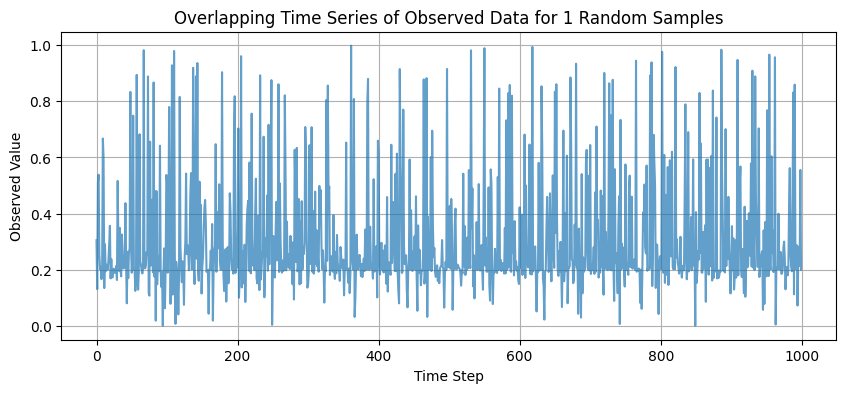

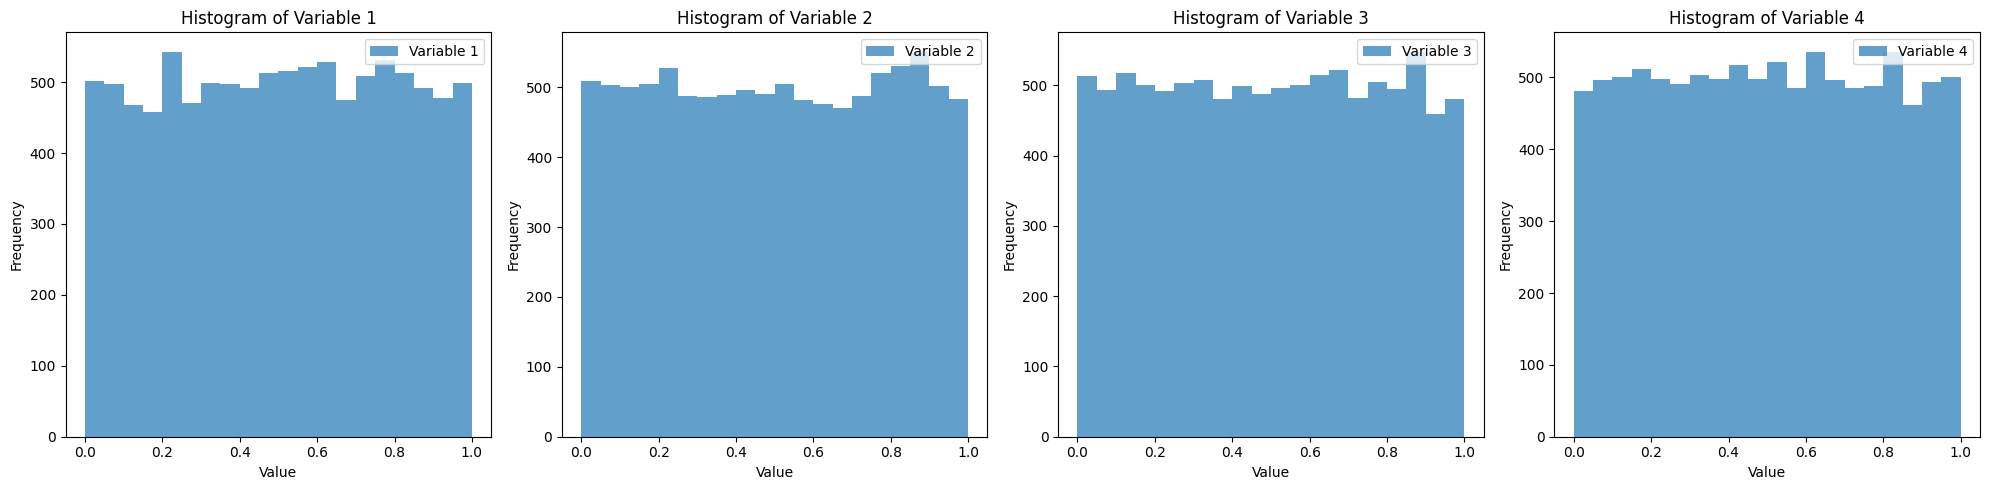

In [8]:
gk_dist.plot_observation(train_data_norm, num_samples =1)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [9]:
input_dim = 4
latent_dim = 16
conditional_dim = 1000
encoder_hidden_dims = [100,100]
decoder_hidden_dims = [2048,2048,2048]
activation_fn = nn.LeakyReLU(0.1)

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=0.01,
)

optimizer = optim.Adam(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=512, shuffle=False)

# network.tune_model(train_loader = train_loader, 
#                 validation_loader = validation_loader,
#                 theta_normalizer=theta_normalizer,
#                 data_normalizer=data_normalizer,
#                 forward_model= gk_dist.simulator)

In [10]:
print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=100, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=1016, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
    (final_layer): Linear(in_features=2048, out_features=4, bias=True)
  )
)


In [11]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=200, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= gk_dist.simulator, patience=50)

Using CPU for training.
Epoch 1/200: Beta: 0.0, total_loss: 2.0183, recon_loss: 1.4140, misfit_loss: 0.6043, kl_div: 0.0000
Epoch 1/200 Validation: Beta: 0.0, total_loss: 1.0591, recon_loss: 0.5803, misfit_loss: 0.4788, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.0001
Epoch 2/200: Beta: 0.1, total_loss: 1.0112, recon_loss: 0.5040, misfit_loss: 0.5041, kl_div: 0.0031
Epoch 2/200 Validation: Beta: 0.1, total_loss: 1.0098, recon_loss: 0.5172, misfit_loss: 0.4919, kl_div: 0.0007

Epoch 2: Validation loss improved to 0.0001
Epoch 3/200: Beta: 0.2, total_loss: 0.9994, recon_loss: 0.4945, misfit_loss: 0.5042, kl_div: 0.0007
Epoch 3/200 Validation: Beta: 0.2, total_loss: 1.0042, recon_loss: 0.4870, misfit_loss: 0.5168, kl_div: 0.0004

Epoch 3: Validation loss improved to 0.0001
Epoch 4/200: Beta: 0.3, total_loss: 0.9972, recon_loss: 0.4922, misfit_loss: 0.5047, kl_div: 0.0003
Epoch 4/200 Validation: Beta: 0.3, total_loss: 0.9981, recon_loss: 0.4816, misfit_loss: 0.5163, kl_div: 0.00

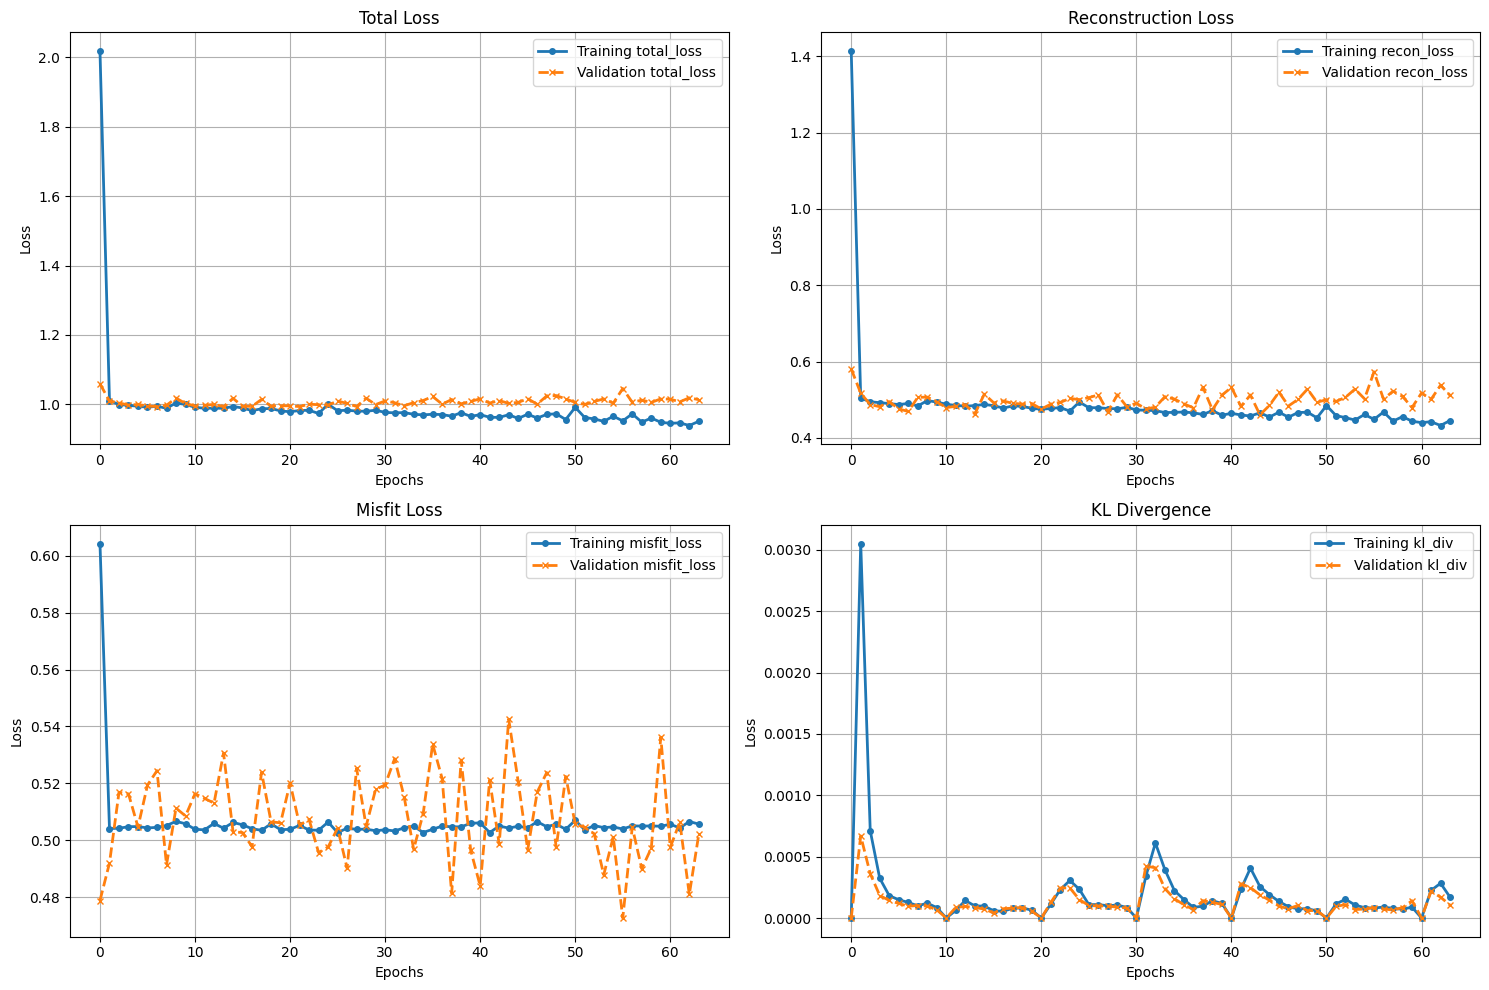

In [12]:
network.plot_loss()

# Inference

In [13]:
post = network.get_posterior(observed_data= observed_data, num_samples=1000)
post = theta_normalizer.inverse_transform(post)


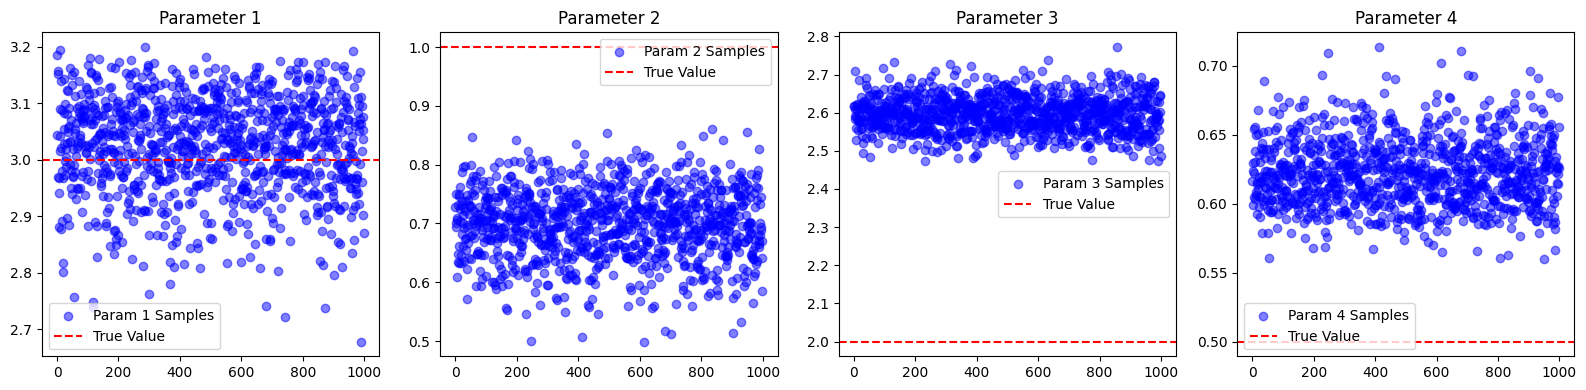

In [14]:
gk_dist.plot_posterior(post)

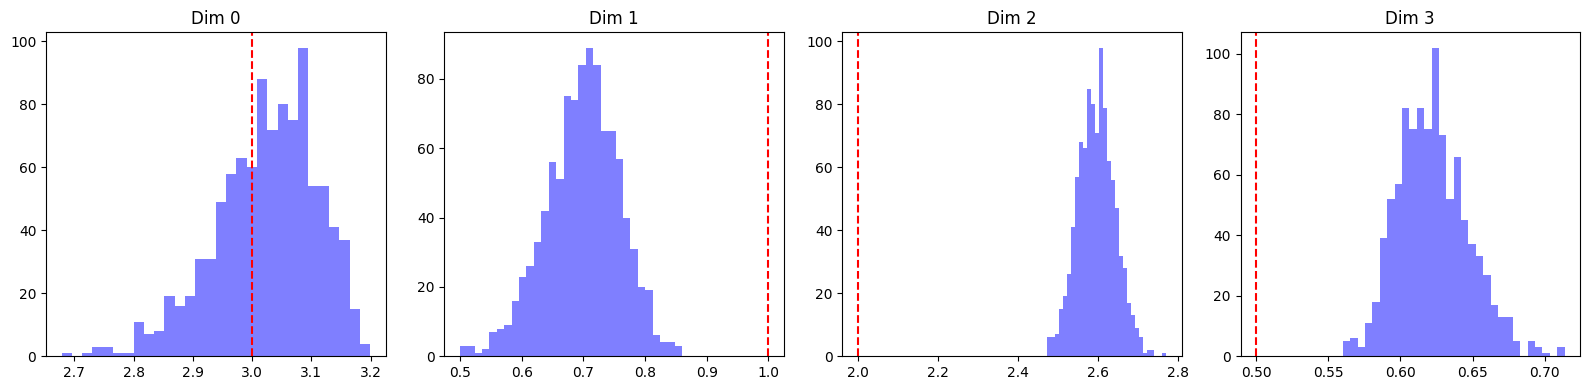

In [15]:
gk_dist.posterior_hist(post)